In [1]:
import time
import numpy as np
import pandas as pd
import psutil
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from scipy.stats import zscore
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

sns.set(style="whitegrid")


In [2]:
def dummy_tee_function(c):
    if c % 2 == 0:
        [x**0.5 for x in range(1000)]
    else:
        [x**2 for x in range(1000)]

def stress_cpu(duration):
    end_time = time.time() + duration
    while time.time() < end_time:
        _ = sum([x**2 for x in range(1000)])


In [3]:
def collect_features(char, stress_duration=0.0):
    times = []
    for _ in range(10):  # mini batch
        if stress_duration > 0:
            stress_cpu(stress_duration)

        start_cpu = psutil.cpu_percent(interval=None)
        start_mem = psutil.virtual_memory().percent
        start = time.perf_counter()

        dummy_tee_function(char)

        end = time.perf_counter()
        end_cpu = psutil.cpu_percent(interval=None)
        end_mem = psutil.virtual_memory().percent

        times.append(end - start)

    return {
        "char": char,
        "avg_time": np.mean(times),
        "std_time": np.std(times),
        "cpu_load": end_cpu,
        "mem_load": end_mem,
    }


In [4]:
def build_dataset(samples_per_digit=100, stress_duration=0.0, condition_label="normal"):
    dataset = []
    print(f"🔄 Starting Collection: {condition_label}")
    for digit in tqdm(range(10), desc=f"{condition_label} Digits"):
        for _ in range(samples_per_digit):
            row = collect_features(digit, stress_duration)
            row["condition"] = condition_label
            dataset.append(row)
    return pd.DataFrame(dataset)


In [5]:
SAMPLES = 100  # per digit for speed (~6-10 min total)

df_normal = build_dataset(SAMPLES, stress_duration=0.0, condition_label="normal")
df_01s = build_dataset(SAMPLES, stress_duration=0.1, condition_label="stressed_0.1s")
df_02s = build_dataset(SAMPLES, stress_duration=0.2, condition_label="stressed_0.2s")
df_05s = build_dataset(SAMPLES, stress_duration=0.5, condition_label="stressed_0.5s")

# Combine all
df_all = pd.concat([df_normal, df_01s, df_02s, df_05s], ignore_index=True)


🔄 Starting Collection: normal



ormal Digits: 100%|███████████████████████████████████████████████████████████████████| 10/10 [01:35<00:00,  9.54s/it]

🔄 Starting Collection: stressed_0.1s



tressed_0.1s Digits: 100%|███████████████████████████████████████████████████████████| 10/10 [18:43<00:00, 112.36s/it]

🔄 Starting Collection: stressed_0.2s



tressed_0.2s Digits: 100%|████████████████████████████████████████████████████████| 10/10 [2:48:27<00:00, 1010.74s/it]

🔄 Starting Collection: stressed_0.5s



tressed_0.5s Digits: 100%|█████████████████████████████████████████████████████████| 10/10 [1:34:10<00:00, 565.08s/it]

c:\users\dharm\appdata\local\programs\python\python39\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 128230 (\N{PACKAGE}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


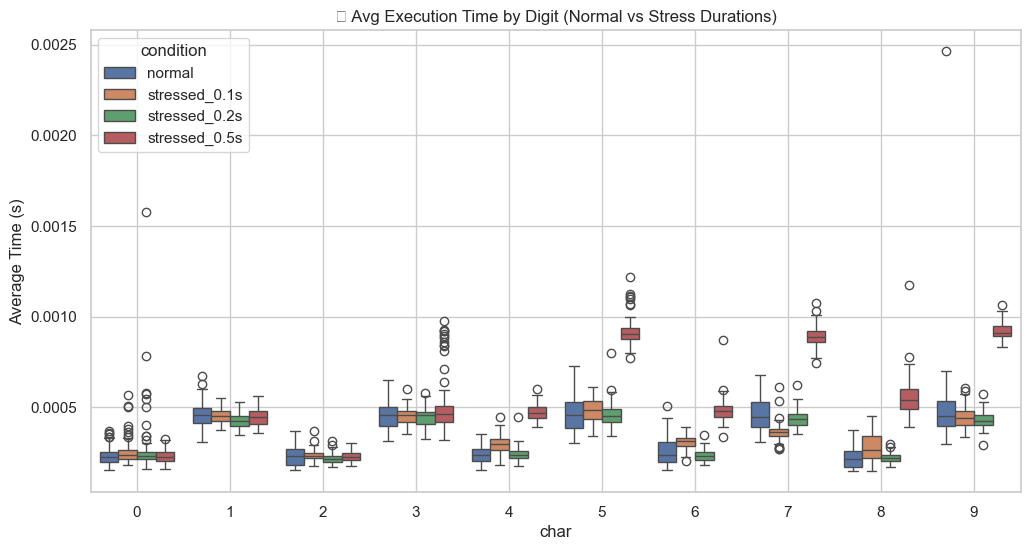

In [6]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=df_all, x='char', y='avg_time', hue='condition')
plt.title("📦 Avg Execution Time by Digit (Normal vs Stress Durations)")
plt.ylabel("Average Time (s)")
plt.grid(True)
plt.show()


c:\users\dharm\appdata\local\programs\python\python39\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 127931 (\N{VIOLIN}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


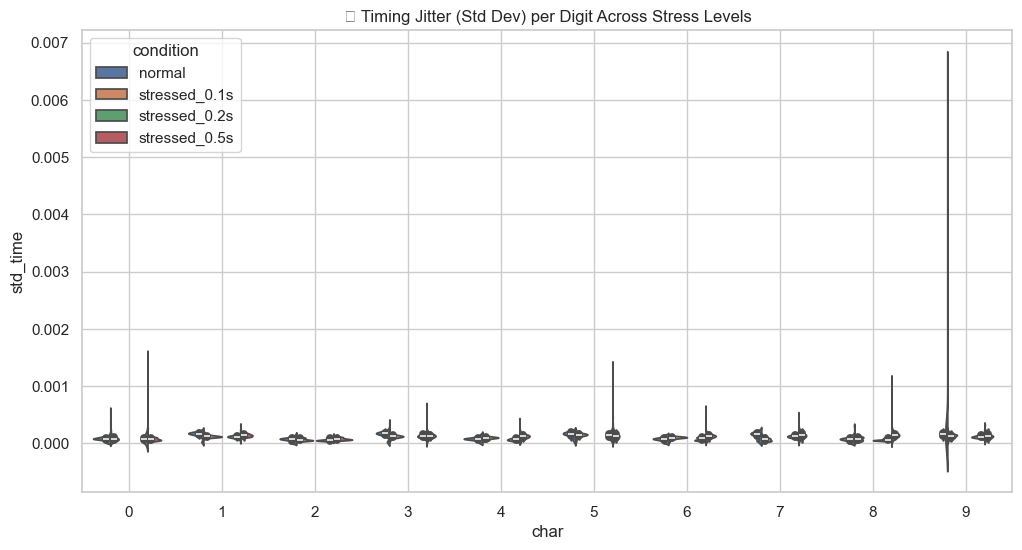

In [7]:
plt.figure(figsize=(12, 6))
sns.violinplot(data=df_all, x='char', y='std_time', hue='condition', split=True)
plt.title("🎻 Timing Jitter (Std Dev) per Digit Across Stress Levels")
plt.grid(True)
plt.show()


c:\users\dharm\appdata\local\programs\python\python39\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 128293 (\N{FIRE}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


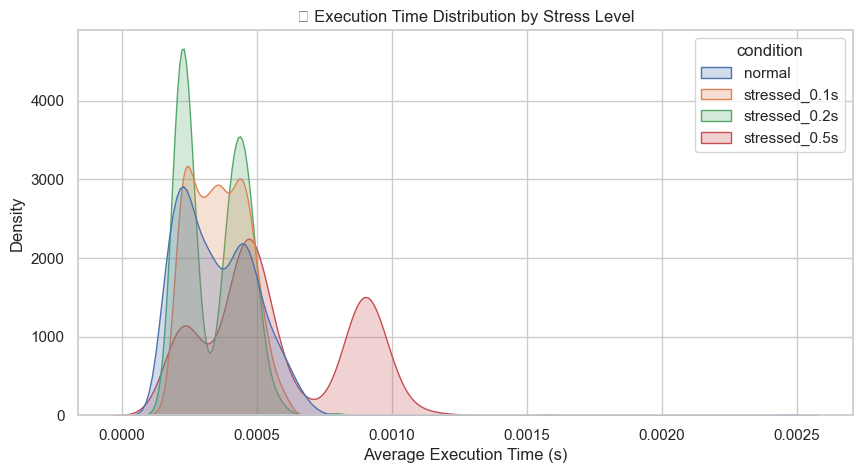

In [8]:
plt.figure(figsize=(10, 5))
sns.kdeplot(data=df_all, x='avg_time', hue='condition', fill=True, common_norm=False)
plt.title("🔥 Execution Time Distribution by Stress Level")
plt.xlabel("Average Execution Time (s)")
plt.grid(True)
plt.show()


c:\users\dharm\appdata\local\programs\python\python39\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


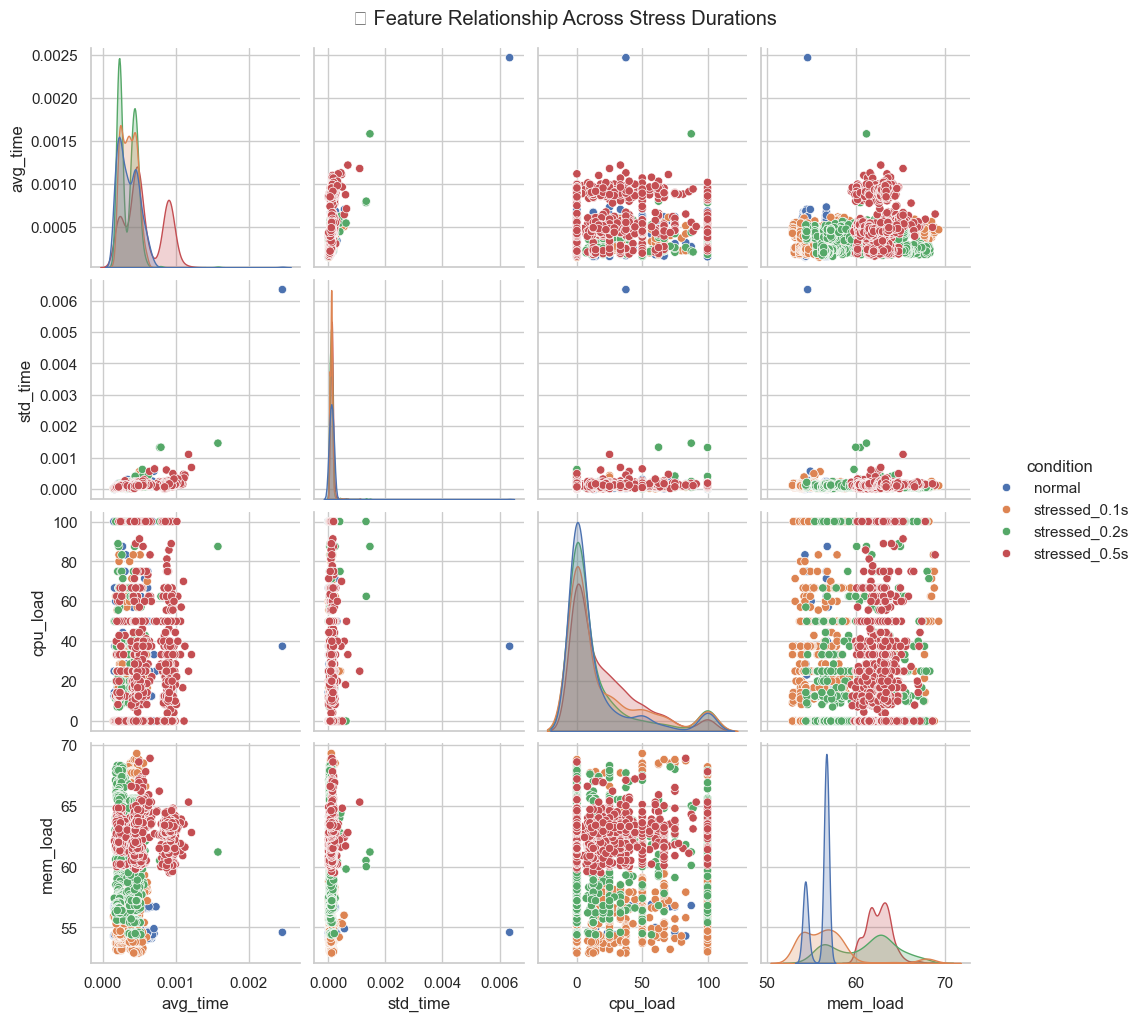

In [9]:
sns.pairplot(df_all, hue="condition", vars=["avg_time", "std_time", "cpu_load", "mem_load"])
plt.suptitle("🔍 Feature Relationship Across Stress Durations", y=1.02)
plt.show()


c:\users\dharm\appdata\local\programs\python\python39\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 129514 (\N{TEST TUBE}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


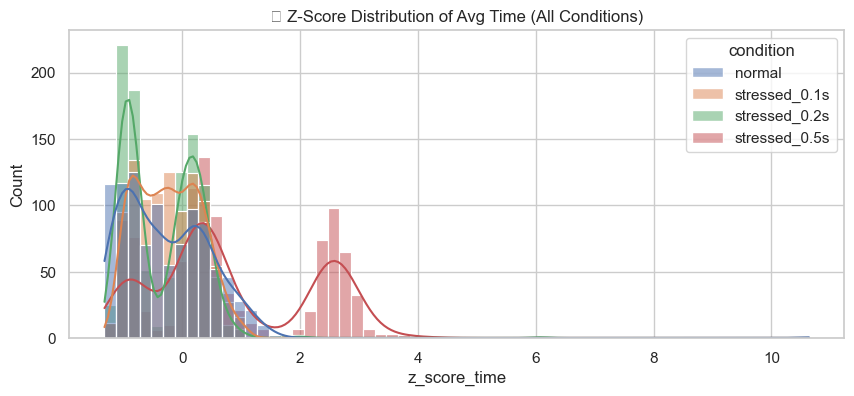

In [10]:
df_all["z_score_time"] = zscore(df_all["avg_time"])

plt.figure(figsize=(10, 4))
sns.histplot(df_all, x="z_score_time", hue="condition", bins=60, kde=True)
plt.title("🧪 Z-Score Distribution of Avg Time (All Conditions)")
plt.grid(True)
plt.show()


In [11]:
X = df_all[["avg_time", "std_time", "cpu_load", "mem_load"]]
y = df_all["char"]

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

model = RandomForestClassifier(n_estimators=100)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print("📊 Classification Report (All Conditions Mixed):")
print(classification_report(y_test, y_pred))


📊 Classification Report (All Conditions Mixed):
              precision    recall  f1-score   support

           0       0.62      0.66      0.64        80
           1       0.51      0.53      0.52        80
           2       0.58      0.56      0.57        80
           3       0.37      0.40      0.39        80
           4       0.38      0.29      0.33        80
           5       0.48      0.50      0.49        80
           6       0.60      0.71      0.65        80
           7       0.72      0.60      0.65        80
           8       0.67      0.60      0.63        80
           9       0.51      0.57      0.54        80

    accuracy                           0.54       800
   macro avg       0.54      0.54      0.54       800
weighted avg       0.54      0.54      0.54       800



In [12]:
df_all.to_csv("side_channel_stress_dataset.csv", index=False)
print("Saved to side_channel_stress_dataset.csv")


Saved to side_channel_stress_dataset.csv


C:\Users\dharm\AppData\Local\Temp\ipykernel_11492\3253885292.py:14: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) Arial.
  plt.tight_layout()
c:\users\dharm\appdata\local\programs\python\python39\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


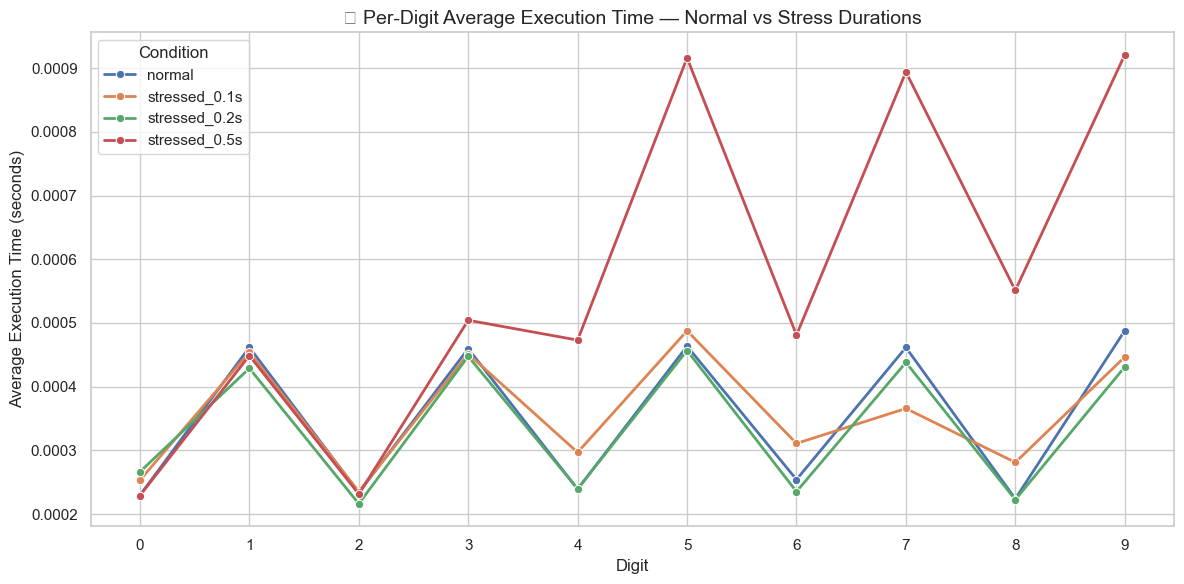

In [13]:
# Group by digit and condition, calculate mean time
avg_times = df_all.groupby(["char", "condition"])["avg_time"].mean().reset_index()

# Plot
plt.figure(figsize=(12, 6))
sns.lineplot(data=avg_times, x="char", y="avg_time", hue="condition", marker="o", linewidth=2)

plt.title("📊 Per-Digit Average Execution Time — Normal vs Stress Durations", fontsize=14)
plt.xlabel("Digit", fontsize=12)
plt.ylabel("Average Execution Time (seconds)", fontsize=12)
plt.xticks(ticks=range(10))
plt.grid(True)
plt.legend(title="Condition")
plt.tight_layout()
plt.show()



In [15]:
import pandas as pd

# Load your CSV
df = pd.read_csv("side_channel_stress_dataset.csv")

# Basic preview
print(df.head())
print(df["condition"].value_counts())  # Check class distribution


   char  avg_time  std_time  cpu_load  mem_load condition  z_score_time
0     0  0.000190  0.000049       0.0      56.8    normal     -1.099190
1     0  0.000218  0.000084      12.5      56.8    normal     -0.954516
2     0  0.000232  0.000106      12.5      56.8    normal     -0.882591
3     0  0.000218  0.000093      66.7      56.8    normal     -0.954567
4     0  0.000218  0.000081      33.3      56.8    normal     -0.955858
condition
normal           1000
stressed_0.1s    1000
stressed_0.2s    1000
stressed_0.5s    1000
Name: count, dtype: int64


In [16]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

# Features and label
X = df[["avg_time", "std_time", "cpu_load", "mem_load"]]
y = df["char"]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.2, random_state=42
)


In [17]:
# Train the model
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Predict
y_pred = model.predict(X_test)


In [18]:
from sklearn.metrics import classification_report

print("📊 Classification Report (All Conditions Mixed):")
print(classification_report(y_test, y_pred))


📊 Classification Report (All Conditions Mixed):
              precision    recall  f1-score   support

           0       0.63      0.65      0.64        80
           1       0.50      0.51      0.51        80
           2       0.60      0.61      0.60        80
           3       0.37      0.40      0.38        80
           4       0.38      0.30      0.34        80
           5       0.52      0.54      0.53        80
           6       0.61      0.68      0.64        80
           7       0.74      0.62      0.68        80
           8       0.63      0.59      0.61        80
           9       0.51      0.56      0.53        80

    accuracy                           0.55       800
   macro avg       0.55      0.55      0.55       800
weighted avg       0.55      0.55      0.55       800



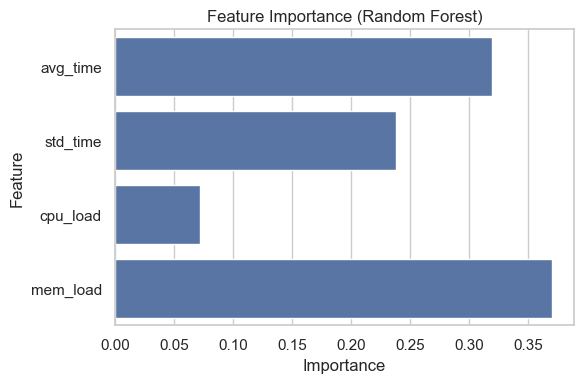

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns

# Feature importances
importances = model.feature_importances_
feature_names = X.columns

# Plot
plt.figure(figsize=(6, 4))
sns.barplot(x=importances, y=feature_names)
plt.title("Feature Importance (Random Forest)")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()


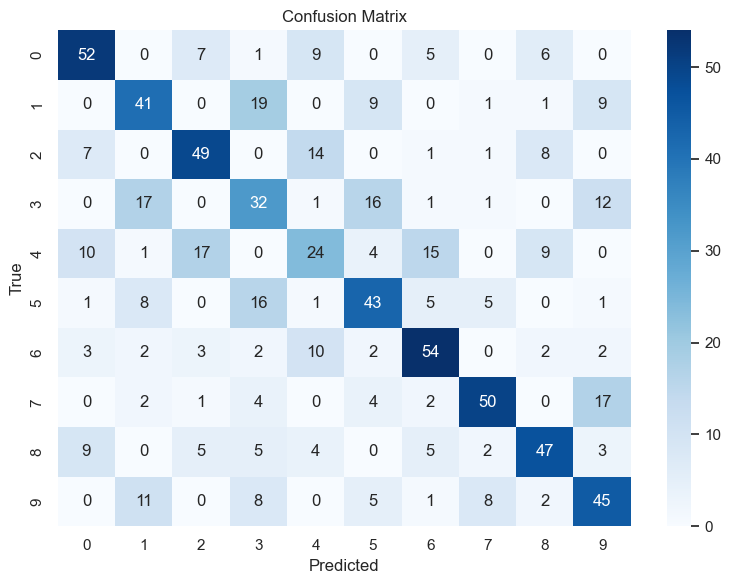

In [20]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import numpy as np

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=range(10), yticklabels=range(10))
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()


In [21]:
for condition in df["condition"].unique():
    subset = df[df["condition"] == condition]
    X = subset[["avg_time", "std_time", "cpu_load", "mem_load"]]
    y = subset["char"]
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, stratify=y, test_size=0.2, random_state=42
    )
    model = RandomForestClassifier(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    print(f"\n📎 Condition: {condition}")
    print(classification_report(y_test, y_pred))



📎 Condition: normal
              precision    recall  f1-score   support

           0       0.77      0.85      0.81        20
           1       0.47      0.40      0.43        20
           2       0.43      0.45      0.44        20
           3       0.44      0.40      0.42        20
           4       0.50      0.35      0.41        20
           5       0.36      0.50      0.42        20
           6       0.70      0.70      0.70        20
           7       0.95      0.90      0.92        20
           8       1.00      0.95      0.97        20
           9       0.86      0.95      0.90        20

    accuracy                           0.65       200
   macro avg       0.65      0.65      0.64       200
weighted avg       0.65      0.65      0.64       200


📎 Condition: stressed_0.1s
              precision    recall  f1-score   support

           0       0.73      0.95      0.83        20
           1       0.89      0.85      0.87        20
           2       1.00      

C:\Users\dharm\AppData\Local\Temp\ipykernel_11492\410769818.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(digit_accuracy.keys()), y=list(digit_accuracy.values()), palette="viridis")
C:\Users\dharm\AppData\Local\Temp\ipykernel_11492\410769818.py:17: UserWarning: Glyph 128290 (\N{INPUT SYMBOL FOR NUMBERS}) missing from font(s) Arial.
  plt.tight_layout()
c:\users\dharm\appdata\local\programs\python\python39\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 128290 (\N{INPUT SYMBOL FOR NUMBERS}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


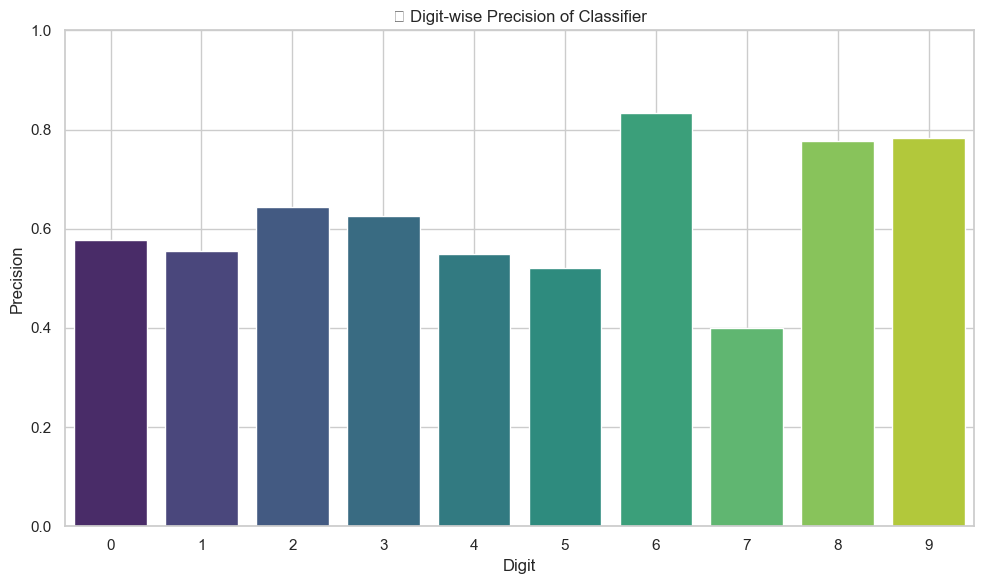

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report

# Generate digit-wise classification report
digit_report = classification_report(y_test, model.predict(X_test), output_dict=True)
digit_accuracy = {k: v['precision'] for k, v in digit_report.items() if k.isdigit()}

# Plot digit-wise precision
plt.figure(figsize=(10, 6))
sns.barplot(x=list(digit_accuracy.keys()), y=list(digit_accuracy.values()), palette="viridis")
plt.title("🔢 Digit-wise Precision of Classifier")
plt.xlabel("Digit")
plt.ylabel("Precision")
plt.ylim(0, 1)
plt.grid(True)
plt.tight_layout()
plt.show()


In [23]:
# Create a DataFrame to store PIN results
import pandas as pd

results_df = pd.DataFrame({
    "True PIN": true_pins,
    "Predicted PIN": predicted_pins
})
results_df["Match"] = results_df["True PIN"] == results_df["Predicted PIN"]

# Plot match count
plt.figure(figsize=(6, 4))
sns.countplot(data=results_df, x="Match", palette="Set2")
plt.title("🔐 Full 4-digit PIN Match Accuracy")
plt.xlabel("Predicted PIN == True PIN?")
plt.ylabel("Count")
plt.xticks([0, 1], ["Incorrect", "Correct"])
plt.tight_layout()
plt.show()


NameError: name 'true_pins' is not defined